In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from tqdm import tqdm
from tensorflow.keras.regularizers import l2
from functools import partial

# Data
from data.data_generator import data_generator
from data.data_generator import data_model
from data.data_filtering import (sanity_checks, est_sanity_checks)

# Model
from models.models import HeteroskedasticModel
from models.models import BayesFlow

# Utils
from utils.losses import heteroskedastic_loss, maximum_likelihood_loss
from utils.training import train_step
from utils.viz import (plot_true_est_scatter, plot_true_est_posterior, 
                       plot_correlation_parameters, plot_comp_post_prior, plot_ts)

%load_ext autoreload
%autoreload 2

In [2]:
# Using Heteroskedastic model as summary net
class SummaryNet(tf.keras.Model):
    def __init__(self, meta):
        super(CustomSummaryNetwork, self).__init__()
        pass
    
    def call(self, x):
        """
        Performs a forward pass through the summary network
        Arguments:
        x : tf.Tensor of shape (batch_size, n_obs, x_dim) - a batch of samples from p(x|params)
        """
        
        # Do something with input
        
        return x

### Training hyperparameters

In [3]:
# Network hyperparameters
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = 5

# Optional if using the predefined summary nets
summary_meta = {
    'n_units': [192, 192, 192],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}


# Forward model hyperparameters
parameter_names = [r'$\beta$', r'$\alpha$', r'$\gamma$', r'$\delta$', r'$\rho$']
theta_dim = len(parameter_names)
n_test = 500


# Training and optimizer hyperparameters
ckpt_file = "SEIDR"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_samples_posterior = 2000

starter_learning_rate = 0.001
global_step = tf.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .95
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate, decay_steps, decay_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)

### Test Data

In [4]:
%%time
data_test = data_generator(n_test)

# Preprocessing untrained data
x_test = np.array(data_test['x'])
theta_test = np.array(data_test['theta'])

CPU times: user 143 ms, sys: 2.86 ms, total: 146 ms
Wall time: 145 ms


In [5]:
print(type(x_test))
print(x_test.shape)
print(type(theta_test))
print(theta_test.shape)

<class 'numpy.ndarray'>
(500, 100, 5)
<class 'numpy.ndarray'>
(500, 5)


In [6]:
# Sanity checks
x_test, theta_test = sanity_checks(x_test, theta_test)

# Sanity checks for numerical stability
assert(np.sum(x_test == np.inf) == 0)
assert(np.sum(x_test == -np.inf) == 0)
assert(np.sum(x_test == np.nan) == 0)

# Reshape x
x_test = x_test.reshape(x_test.shape[0], -1)

In [7]:
print(x_test.shape)
print(theta_test.shape)

(500, 500)
(500, 5)


### Networks

In [8]:
# Instantiate model
summary_net = HeteroskedasticModel(summary_meta)
model = BayesFlow(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)

### Compile

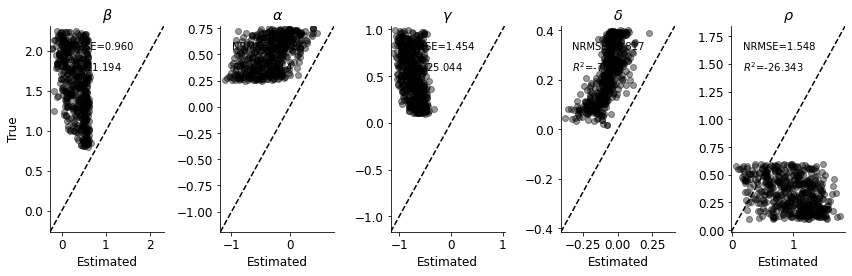

In [9]:
plot_true_est_scatter(model, x_test, theta_test, n_samples_posterior, parameter_names, figsize=(12, 4))

### Manage Checkpoints

In [10]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/SEIDR/ckpt-612


### Training network

In [12]:
# %%time
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_step(model=model, 
                            optimizer=optimizer,
                            loss_fn=maximum_likelihood_loss, 
                            iterations=iterations_per_epoch,
                            batch_size=batch_size,
                            p_bar=p_bar,
                            global_step=global_step) 

        # Manage checkpoint
        manager.save()

Training epoch 100: 100%|██████████| 1000/1000 [01:43<00:00,  9.64it/s, Iteration: 1000, Loss: -31.573402404785156]


### Posterior means & Full posteriors

In [11]:
# Estimation sanity checks
theta_samples = model.sample(x_test, n_samples_posterior, to_numpy=True)
theta_approx_means = theta_samples.mean(axis=0)

In [12]:
ftheta_approx_means, ftheta_test, fx_test = est_sanity_checks(theta_approx_means, theta_test, x_test=x_test)

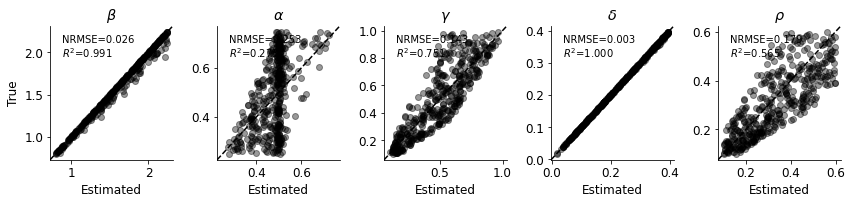

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


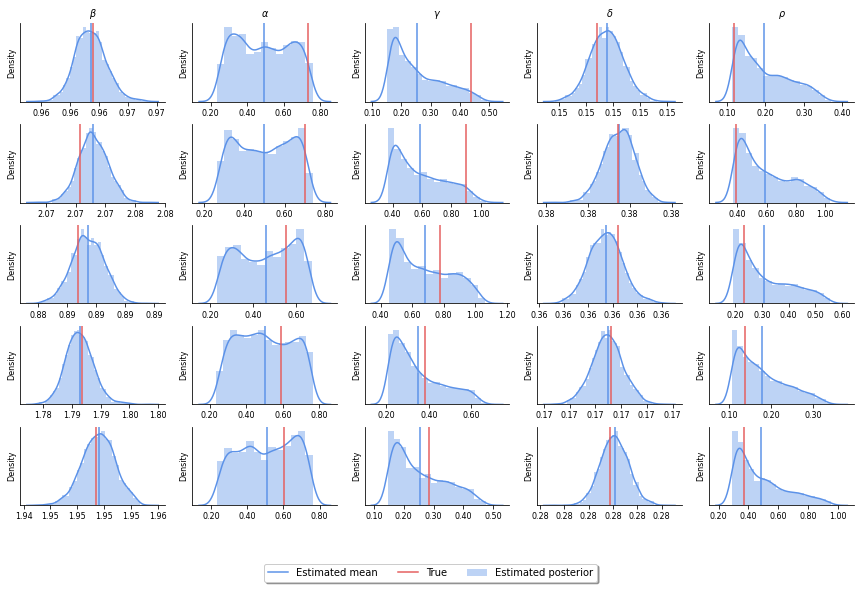

In [13]:
plot_true_est_scatter(model, fx_test, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=ftheta_approx_means)

plot_true_est_posterior(model, 2000, parameter_names, font_size=8,
                        X_test=fx_test[:5], 
                        theta_test=ftheta_test[:5], figsize=(12, 8))

In [14]:
# Posteriors of randomly selected sample
rand_sample_idx = np.random.choice(theta_samples.shape[0], 1, replace=False)
sel_sample = theta_samples[rand_sample_idx].squeeze()

In [15]:
fsel_sample, ftheta_test, fx_test = est_sanity_checks(sel_sample, theta_test, x_test)

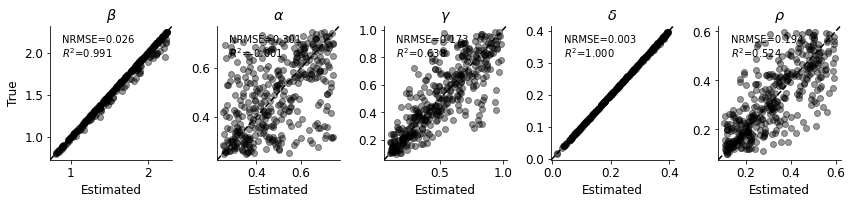

In [16]:
plot_true_est_scatter(model, fx_test, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=fsel_sample)

### Correlation of parameters

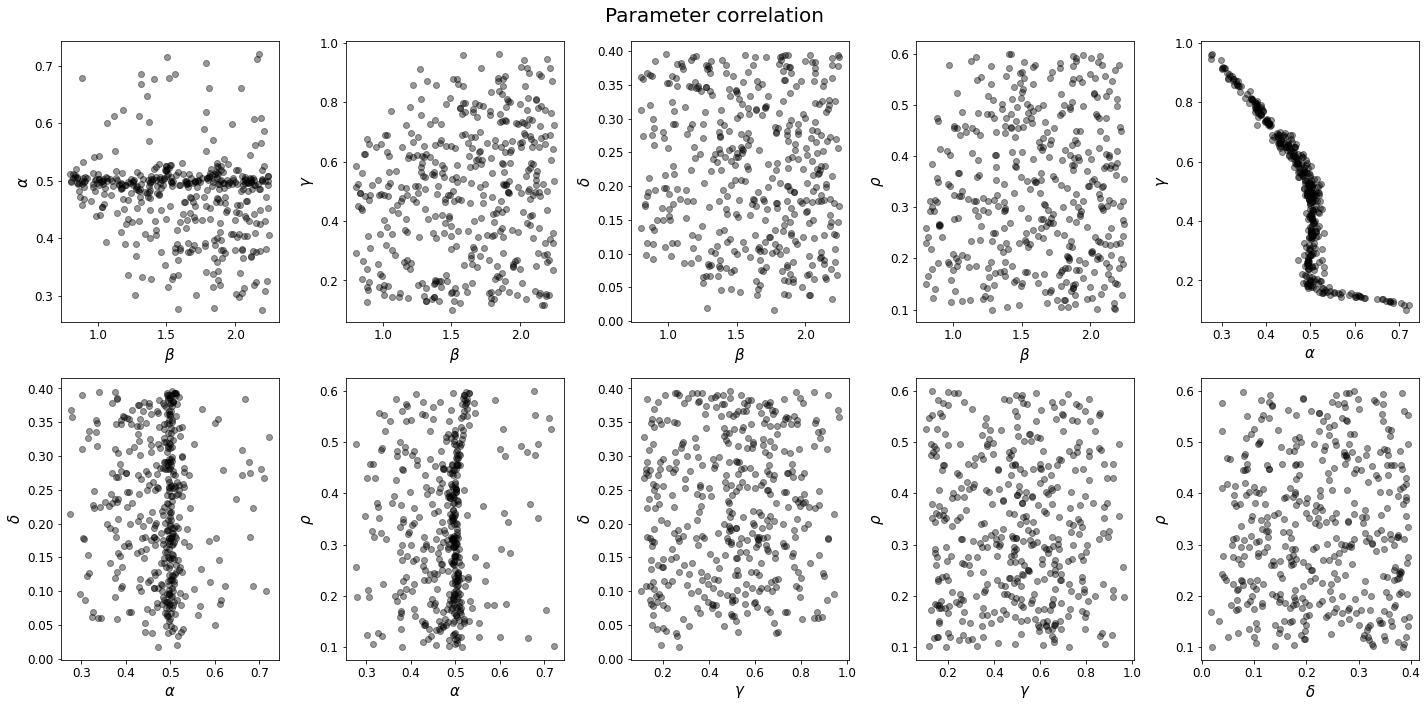

<Figure size 1440x720 with 0 Axes>

In [17]:
plot_correlation_parameters(ftheta_approx_means, parameter_names)

### Re-simulation

In [18]:
# Forward model using selected sample
t_obs = 100
dt = 1
t = np.linspace(0, t_obs, int(t_obs/dt))
N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0
forward_model = partial(data_model, initial_values=init_vals)

ts = np.empty((fsel_sample.shape[0], t_obs, 5))
          
for i in range(fsel_sample.shape[0]):
    ts[i, :, :] = forward_model(fsel_sample[i, :], t=t)

ts = ts.reshape(fsel_sample.shape[0], -1)

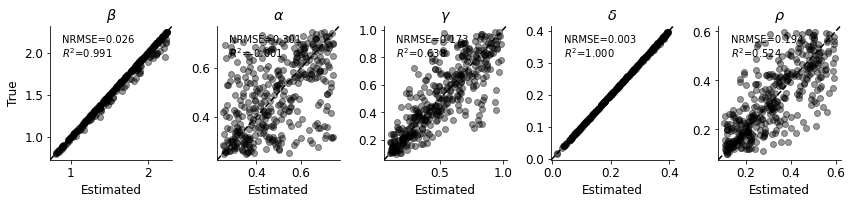

In [19]:
plot_true_est_scatter(model, ts, ftheta_test, n_samples_posterior, parameter_names, figsize=(12, 3), theta_approx_means=fsel_sample)

### Compartiment time series of randomly selected sample

In [20]:
# Estimation sanity check
rand_params_index = np.random.choice(fsel_sample.shape[0], 1, replace=False)
sel_params = fsel_sample[rand_params_index].squeeze()

In [21]:
parameters = sel_params

ts = forward_model(parameters, t=t)
labels = ['S', 'E', 'I', 'R', 'D']

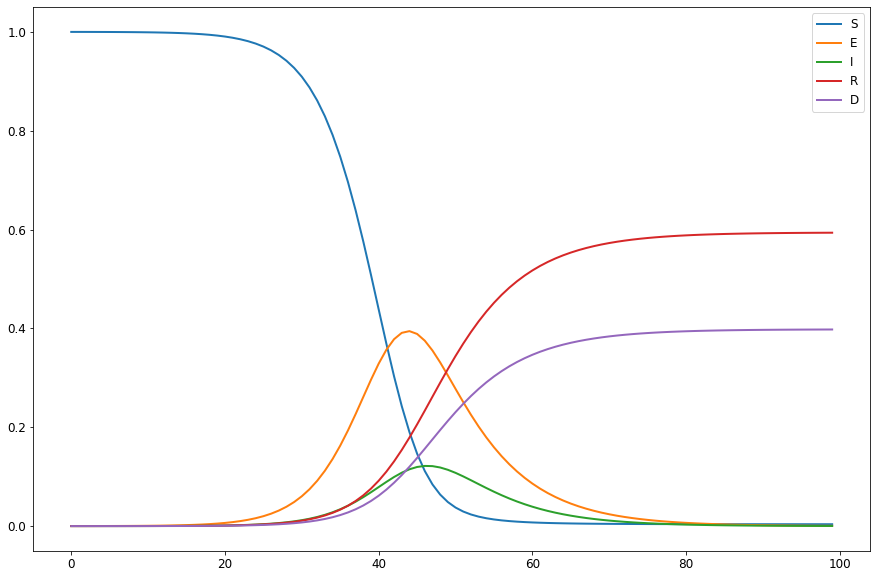

In [22]:
f, ax = plt.subplots(1, 1, figsize=(15, 10))
for i in range(5):
    ax.plot(ts[:, i], label=labels[i], lw=2)

plt.legend()

# ts_t = tf.convert_to_tensor(ts[np.newaxis].reshape(1, -1), dtype=tf.float32)


# theta_hat = model.sample(ts_t, 5000, to_numpy=True)

# f, axarr = plt.subplots(1, 5, figsize=(12, 3))
# for i in range(5):
#     sns.distplot(theta_hat[:, i], ax=axarr[i], kde=False)
#     axarr[i].axvline(parameters[i], color='black')
    
# f.tight_layout()

### Plot predictions

The idea is to filter the theta_samples with the sanity checks and set invalid tuples to None

Then, calculate time series with forward modelfor all non-NaN parameter tuples

In [23]:
theta_samples.shape

(2000, 500, 5)

In [24]:
idxs = []
for i in range(theta_samples.shape[0]):
    _, _, mask_idx = est_sanity_checks(theta_samples[i, :, :], theta_test, idx_mask=True)
    idxs.append(np.unique(mask_idx))

In [25]:
# Set invalid parameters to None
for i in range(theta_samples.shape[0]):
    theta_samples[i, :, :][idxs[i]] = None

In [37]:
theta_samples[0, 394]

array([1.6309526 , 0.6716472 , 0.8874103 , 0.12733182, 0.2056621 ],
      dtype=float32)

In [28]:
# Calculate time series with forward model for non-NaN parameters
t = np.linspace(0, t_obs, int(t_obs/dt))
ts = np.empty((fsel_sample.shape[0], fsel_sample.shape[0], t_obs, 5))
ts[:, :, :, :] = np.NaN

for i in range(theta_samples.shape[0]):
    for j in range(theta_samples.shape[1]):
        if theta_samples[i, j, :].sum() != np.NaN:
            print(j)
            ts[i, j, :, :] = forward_model(theta_samples[i, j, :], t=t)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

IndexError: index 393 is out of bounds for axis 1 with size 393

In [110]:
# Calculate stats
ts_means = np.nanmean(ts, axis=0)

<ipython-input-110-4aff6af61b55>:2: RuntimeWarning: Mean of empty slice
  ts_means = np.nanmean(ts, axis=0)


In [111]:
ts_means

array([[[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       ...,

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]],

       [[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan

In [29]:
ts_means.shape

(500, 100, 5)

In [25]:
t = np.linspace(0, t_obs, int(t_obs/dt))
ts = np.empty((fsel_sample.shape[0], t_obs, 5))
          
for i in range(fsel_sample.shape[0]):
    ts[i, :, :] = forward_model(fsel_sample[i, :], t=t)

In [26]:
ts.shape

(395, 100, 5)

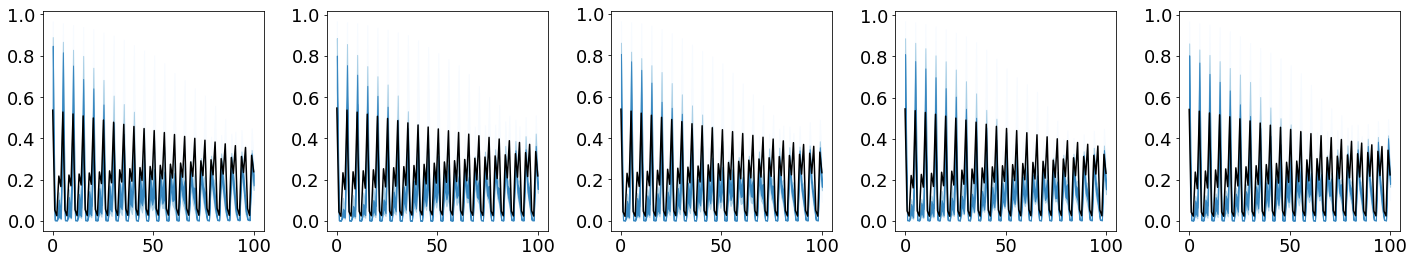

In [64]:
plot_ts(t, ts, labels, cmean='black')